In [14]:
import pandas as pd

In [15]:
datos=pd.read_csv("Caffeine_abs_2.csv")

In [16]:
datos.head(20)

,nm,A
0,190.0,NaN
1,190.5,NaN
2,191.0,NaN
3,191.5,NaN
4,192.0,NaN
5,192.5,NaN
6,193.0,NaN
7,193.5,NaN
8,194.0,NaN
9,194.5,NaN


In [17]:
x=datos["nm"]
y=datos["A"]

#### contamos los valores de cada columna del archivo "Caffeine_abs_2.csv"

In [18]:
datos["nm"].value_counts()

nm
190.0    1
335.0    1
340.5    1
340.0    1
339.5    1
        ..
262.0    1
261.5    1
261.0    1
260.5    1
410.0    1
Name: count, Length: 441, dtype: int64

In [19]:
datos["A"].value_counts()

A
0.004    21
0.003    21
0.002    16
0.005    14
0.006    12
         ..
0.388     1
0.418     1
0.433     1
0.449     1
0.042     1
Name: count, Length: 195, dtype: int64

### Hacemos una primer gráfica usando seaborn

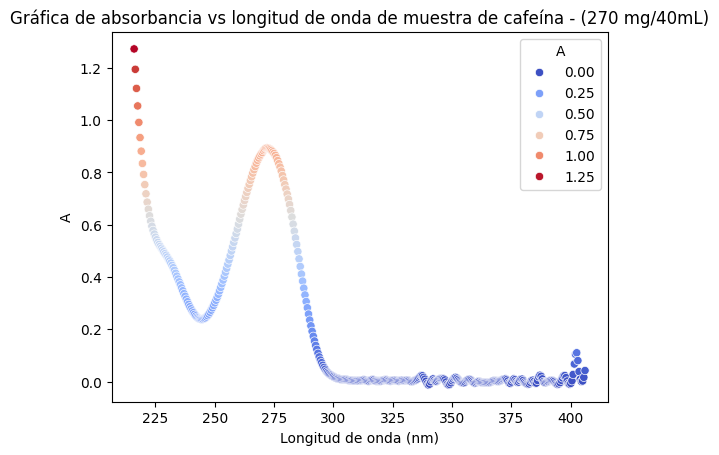

In [22]:
import seaborn as sb
import matplotlib.pyplot as plt

sb.scatterplot(x="nm", y="A", data=datos, hue="A", palette="coolwarm")
plt.title("Gráfica de absorbancia vs longitud de onda de muestra de cafeína - (270 mg/40mL)")
plt.xlabel("Longitud de onda (nm)")
plt.ylabel("A")
plt.show()

array([[<Axes: title={'center': 'nm'}>, <Axes: title={'center': 'A'}>]],
      dtype=object)

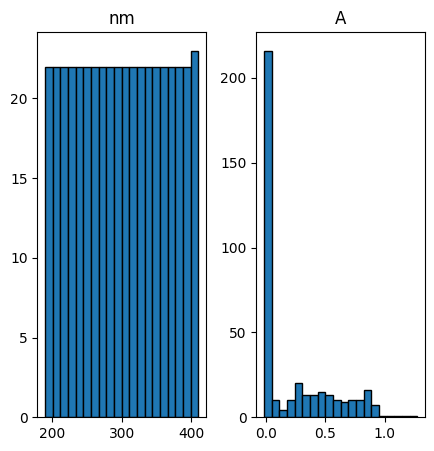

In [23]:
datos.hist(figsize=(5,5), bins=20, edgecolor="black", grid=False)

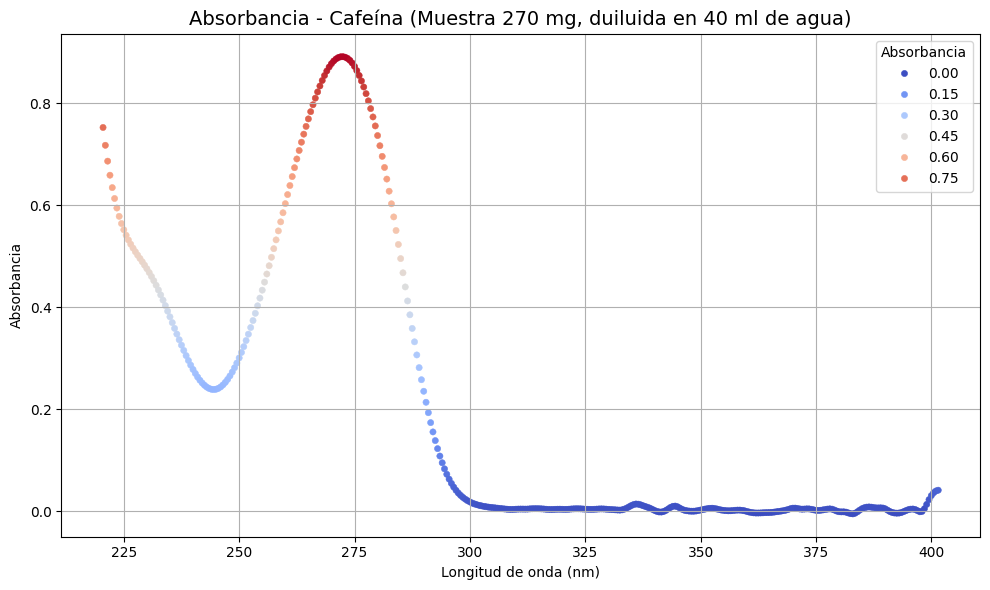

In [24]:
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import seaborn as sb

# creamos columna suavizada

datos["A_suave"]=savgol_filter(datos["A"], window_length=19, polyorder=3)

#graficamos el scatterplot con suavizado y gradiente de color

plt.figure(figsize=(10,6))
sb.scatterplot(x="nm", y="A_suave", data =datos, hue="A_suave", palette="coolwarm", s=20, edgecolor=None)
plt.title("Absorbancia - Cafeína (Muestra 270 mg, duiluida en 40 ml de agua)", fontsize=14)
plt.xlabel("Longitud de onda (nm)")
plt.ylabel("Absorbancia")
plt.legend(title='Absorbancia', loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

In [3]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
import os

# === Archivo absorbancia cafeína ===
archivo_abs = 'Caffeine_abs_2.csv'  # Ruta al CSV

# === Regiones espectrales cafeína (190-410 nm) ===
regiones = {
    '220–250 nm': (220, 250),
    '250–300 nm': (250, 300),
    '300–350 nm': (300, 350)
}

# === Ruta base relativa
ruta_base = os.path.dirname(os.path.abspath(archivo_abs))

# === Función para leer datos y limpiar ===
def leer_csv(filepath):
    df = pd.read_csv(filepath)
    df.columns = [c.strip().lower() for c in df.columns]
    if not set(['nm', 'a']).issubset(df.columns):
        raise ValueError("El CSV debe tener columnas 'nm' y 'a'.")
    df['nm'] = pd.to_numeric(df['nm'], errors='coerce')
    df['a'] = pd.to_numeric(df['a'], errors='coerce')
    return df.dropna()

# === Cargar datos ===
datos_abs = {'Cafeína': leer_csv(archivo_abs)}

# === Colores (hex) para las curvas ===
colores_plotly = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
    '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
    '#bcbd22', '#17becf'
]

# === Figura principal (solo absorbancia) ===
fig = make_subplots(
    rows=1, cols=1,
    subplot_titles=("Curva de absorbancia - Cafeína",),
    shared_xaxes=False,
    shared_yaxes=False
)

metricas = []

# === Absorbancia ===
for i, (nombre, df) in enumerate(datos_abs.items()):
    df = df[(df['nm'] >= 220) & (df['nm'] <= 350)].reset_index(drop=True)
    datos = df[['nm', 'a']].dropna().rename(columns={'a': 'valor'})
    fig.add_trace(go.Scatter(
        x=datos['nm'],
        y=datos['valor'],
        mode='lines',
        name=nombre,
        line=dict(color=colores_plotly[i % len(colores_plotly)])
    ), row=1, col=1)

    # === Métricas
    max_val = datos['valor'].max()
    min_val = datos['valor'].min()
    avg = datos['valor'].mean()
    std = datos['valor'].std()
    auc = np.trapezoid(datos['valor'], datos['nm'])  # Integración con trapz
    lambda_max = datos['nm'][datos['valor'].idxmax()]
    lambda_min = datos['nm'][datos['valor'].idxmin()]

    proms_reg = {}
    for region, (a, b) in regiones.items():
        reg_vals = datos.loc[(datos['nm'] >= a) & (datos['nm'] <= b), 'valor']
        proms_reg[region] = f"{reg_vals.mean():.3f}" if not reg_vals.empty else "—"

    metricas.append({
        'Tipo': 'Absorbancia',
        'Color de curva': colores_plotly[i % len(colores_plotly)],
        'Curva': nombre,
        'Máx': round(max_val, 3),
        'Mín': round(min_val, 3),
        'Promedio': round(avg, 3),
        'Desv. Std': round(std, 3),
        'AUC': round(auc, 3),
        'λ máx (nm)': round(lambda_max, 2),
        'λ mín (nm)': round(lambda_min, 2),
        **proms_reg
    })

# === Tabla HTML ===
df_metricas = pd.DataFrame(metricas)
tabla_html = "<table class='styled-table'><thead><tr>"
for col in df_metricas.columns:
    tabla_html += f"<th>{col}</th>"
tabla_html += "</tr></thead><tbody>"
for _, row in df_metricas.iterrows():
    tabla_html += "<tr>"
    for col in df_metricas.columns:
        if col == "Color de curva":
            tabla_html += f"<td style='background-color:{row[col]};'></td>"
        else:
            tabla_html += f"<td>{row[col]}</td>"
    tabla_html += "</tr>"
tabla_html += "</tbody></table>"

# === Estética gráfica ===
fig.update_layout(
    title="Curva de absorbancia - Cafeína",
    title_font_size=24,
    title_x=0.05,
    plot_bgcolor="white",
    paper_bgcolor="white",
    font=dict(family="Arial", size=14, color="black"),
    margin=dict(l=80, r=50, t=80, b=60),
    height=650,
)

fig.update_xaxes(
    title_text="Longitud de onda (nm)",
    title_font=dict(size=16),
    tickfont=dict(size=12),
    showline=True,
    linecolor='black',
    mirror=True,
    showgrid=True,
    gridcolor='lightgray'
)

fig.update_yaxes(
    title_text="Absorbancia",
    title_font=dict(size=16),
    tickfont=dict(size=12),
    showline=True,
    linecolor='black',
    mirror=True,
    showgrid=True,
    gridcolor='lightgray'
)

# === HTML Final ===
fecha = datetime.now().strftime('%d-%m-%Y %H:%M:%S')
grafica_html = fig.to_html(full_html=False, include_plotlyjs='cdn')

html_final = f"""
<!DOCTYPE html>
<html lang="es">
<head>
  <meta charset="UTF-8">
  <title>Reporte UV-Vis - Cafeína</title>
  <meta name="viewport" content="width=device-width, initial-scale=1.0">
  <style>
    body {{
      font-family: 'Segoe UI', Tahoma, sans-serif;
      margin: 40px;
      background-color: #fdfdfd;
      color: #222;
    }}
    h1 {{
      color: #111;
    }}
    h2 {{
      margin-top: 40px;
    }}
    .info {{
      margin-bottom: 20px;
    }}
    .lab {{
      margin-top: 40px;
      font-size: 0.95em;
      background-color: #f0f8ff;
      padding: 15px;
      border-left: 6px solid #009879;
    }}
    .styled-table {{
      border-collapse: collapse;
      margin-top: 20px;
      font-size: 1em;
      width: 100%;
      box-shadow: 0 0 10px rgba(0, 0, 0, 0.05);
    }}
    .styled-table thead tr {{
      background-color: #009879;
      color: #ffffff;
      text-align: left;
    }}
    .styled-table th, .styled-table td {{
      padding: 12px 15px;
      border: 1px solid #ddd;
      text-align: center;
    }}
    .styled-table tbody tr:nth-child(even) {{
      background-color: #f3f3f3;
    }}
    .plotly-graph-div {{
      width: 100% !important;
      height: auto !important;
    }}
  </style>
</head>
<body>

  <h1>Curva de absorbancia - Cafeína</h1> 

  <div class="info">
    <p><strong>Fecha:</strong> {fecha}</p>
  </div>

  {grafica_html}

  <h2>Métricas espectrales</h2>
  {tabla_html}

  <div>
    <p>La curva muestra el comportamiento espectral de la cafeína en el rango UV-Vis, resaltando las regiones de máxima y mínima absorbancia y su distribución promedio en subrangos definidos.</p>
  </div>

  <div class="lab">
    <strong>Nombre del proyecto: Cafeína UV-Vis</strong><br><br>
    <strong>Colaboradores:</strong><br>
    Martín Rodolfo Palomino Merino – Profesor investigador, jefe responsable del laboratorio de caracterización de materiales (FCFM-BUAP).<br>
    Lizeth Jazmín Orozco García – Colaboradora principal.<br>
    Julio Alfredo Ballinas García – Colaborador del proyecto.
  </div>

</body>
</html>
"""

# === Guardar archivo ===
ruta_salida = os.path.join(ruta_base, "Reporte_Cafeina_UVVis.html")
with open(ruta_salida, "w", encoding="utf-8") as f:
    f.write(html_final)

print(f"Reporte guardado en: {ruta_salida}")
fig.show()


Reporte guardado en: /home/jabg20/Desktop/CAFELAB/Caffeine_ABS/Reporte_Cafeina_UVVis.html
